In [1]:
!pip install -q pytorch_lightning

     |████████████████████████████████| 798 kB 13.4 MB/s 
     |████████████████████████████████| 529 kB 51.3 MB/s 
     |████████████████████████████████| 87 kB 3.4 MB/s 


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import cv2

import os
import csv
import json
import tqdm
import pickle
import typing
import random
from collections import OrderedDict
import matplotlib.pyplot as plt

import numpy as np
from concurrent.futures import ProcessPoolExecutor
from sklearn.neighbors import KNeighborsClassifier


CLASSES_CNT = 205

## Raw data explore

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 3/CV/09_Traffic_signs/data.zip data.zip

In [6]:
!unzip -q data.zip -d ./

In [7]:
!rm ./cropped-train/.DS_Store

---

In [12]:
!ls 

background_images  data      icons	  smalltest
classes.json	   data.zip  __MACOSX	  smalltest_annotations.csv
cropped-train	   drive     sample_data


In [14]:
!head smalltest_annotations.csv

filename,class
0.png,5.12.1
1.png,8.3.1
2.png,8.3.1
3.png,8.3.1
4.png,8.3.1
5.png,8.3.1
6.png,8.3.1
7.png,8.3.1
8.png,4.5.1


In [15]:
!head classes.json

{
    "1.1": {
        "id": 0,
        "type": "freq"
    },
    "1.10": {
        "id": 1,
        "type": "rare"
    },
    "1.11.1": {


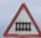

In [16]:
Image.open('cropped-train/1.1/012216.png')

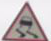

In [36]:
Image.open('smalltest/10.png')

---

### Dataset

In [75]:
def calc_metric(y_true, y_pred, cur_type, class_name_to_type):
    """
    cur_type ~ ['all', 'rare', 'freq']
    """
    ok_cnt = 0
    all_cnt = 0
    for t, p in zip(y_true, y_pred):
        if cur_type == 'all' or class_name_to_type[t] == cur_type:
            all_cnt += 1
            if t == p:
                ok_cnt += 1
    return ok_cnt / max(1, all_cnt)


class DatasetRTSD(torch.utils.data.Dataset):
    """
    Класс для чтения и хранения датасета.
    :param root_folders: список путей до папок с данными
    :param path_to_classes_json: путь до classes.json
    """
    def __init__(self, root_folders, path_to_classes_json) -> None:
        super(DatasetRTSD, self).__init__()
        self.classes, self.class_to_idx = self.get_classes(path_to_classes_json)
        
        ### YOUR CODE HERE - список пар (путь до картинки, индекс класса)
        self.samples = []
        for root in root_folders:
            class_folders = os.listdir(root)
            for class_name in class_folders:
                path = os.path.join(root, class_name)
                self.samples += [(os.path.join(path, img), self.class_to_idx[class_name]) for img in os.listdir(path)]
        
        ### YOUR CODE HERE - cловарь из списков картинок для каждого класса, 
        ### classes_to_samples[индекс класса] = [список чисел-позиций картинок в self.samples]
        self.classes_to_samples = {c: [] for c in range(len(self.classes))}
        for i, (_, v) in enumerate(self.samples):
            self.classes_to_samples[v] += [i]
        
        ### YOUR CODE HERE - аугментации + нормализация + ToTensorV2
        self.transform = A.Compose([
            A.Resize(72, 72, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=30, p=0.5),
            A.RGBShift(p=0.5),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        """
        Возвращает тройку: тензор с картинкой, путь до файла, номер класса файла (если нет разметки, то "-1").
        """
        ### YOUR CODE HERE
        img_path, class_index = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        image = np.array(image).astype(np.float32)
        image = self.transform(image=image)['image']
        return image, img_path, class_index
    
    @staticmethod
    def get_classes(path_to_classes_json):
        """
        Считывает из classes.json информацию о классах.
        :param path_to_classes_json: путь до classes.json
        """
        with open(path_to_classes_json) as j:
            data = json.load(j)

        ### YOUR CODE HERE - словарь, class_to_idx['название класса'] = индекс
        class_to_idx = {k: v['id'] for k, v in data.items()} 

        ### YOUR CODE HERE - массив, classes[индекс] = 'название класса'
        classes = list(class_to_idx.keys())
        return classes, class_to_idx


class TestData(torch.utils.data.Dataset):
    """
    Класс для чтения и хранения тестового датасета.
    :param root: путь до папки с картинками знаков
    :param path_to_classes_json: путь до classes.json
    :param annotations_file: путь до .csv-файла с аннотациями (опциональный)
    """
    def __init__(self, root, path_to_classes_json, annotations_file=None):
        super(TestData, self).__init__()
        self.root = root
        
        ### YOUR CODE HERE - список картинок
        self.samples = [img for img in os.listdir(root)]
        
        ### YOUR CODE HERE - преобразования: ресайз + нормализация + ToTensorV2
        self.transform = A.Compose([
            A.Resize(64, 64, p=1.0),
            A.Normalize(),
            ToTensorV2()
        ])
        
        ### YOUR CODE HERE - словарь, targets[путь до картинки] = индекс класса
        self.targets = None
        if annotations_file is not None:
            with open(path_to_classes_json) as j:
                data = json.load(j)
            class_to_idx = {k: v['id'] for k, v in data.items()} 
            
            self.targets = {}
            with open(annotations_file) as f:
                next(f)
                for line in f:
                    filename, class_name = line.rstrip('\n').split(',')
                    self.targets[filename] = class_to_idx[class_name]

    def __len__(self):
        return len(self.samples)                
                    
    def __getitem__(self, index):
        """
        Возвращает тройку: тензор с картинкой, имя файла, номер класса файла (если нет разметки, то "-1").
        """
        ### YOUR CODE HERE
        filename = self.samples[index]
        img_path = os.path.join(self.root, filename)
        if self.targets:
            class_index = self.targets.get(filename, -1)
        else:
            class_index = -1
        image = Image.open(img_path).convert('RGB')
        image = np.array(image).astype(np.float32)
        image = self.transform(image=image)['image']
        return image, filename, class_index

### Simple model

In [ ]:
#         if features_criterion:
#             self.features_criterion = features_criterion(2)
#             self.features_nn = self.model
#             self.features_nn.classifier = nn.Identity()
#         else:
#             self.features_criterion = None
#             self.features_nn = None

In [76]:
class CustomNetwork(pl.LightningModule):
    """
    Класс, реализующий нейросеть для классификации.
    :param features_criterion: loss-функция на признаки, извлекаемые нейросетью перед классификацией (None когда нет такого лосса)
    :param internal_features: внутреннее число признаков
    """
    def __init__(self, features_criterion=None, internal_features=1024, pretrained=False):
        super(CustomNetwork, self).__init__()
        ### YOUR CODE HERE
        self.model = models.resnet50(pretrained=pretrained)
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, internal_features),
            nn.ReLU(),
            nn.Linear(internal_features, CLASSES_CNT)
        )

        # Freeze all layers except last 4 layers
        for child in list(self.model.children()):
            for param in child.parameters():
              param.requires_grad = True
        for child in list(self.model.children())[:-4]:
            for param in child.parameters():
              param.requires_grad = False

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)
    
    def training_step(self, batch):
        image, _, label = batch
        logits = self.forward(image)
        loss = F.nll_loss(logits, label)
        acc = (logits.argmax(dim=1) == label).sum().item() / len(logits)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return [optimizer]
        
    def predict(self, x):
        """
        Функция для предсказания классов-ответов. Возвращает np-массив с индексами классов.
        :param x: батч с картинками
        """
        ### YOUR CODE HERE
        out = self.forward(x)
        labels = out.argmax(dim=1).detach().cpu().numpy()
        return labels

#### Train/apply/evaluate

In [77]:
def train_simple_classifier():
    """Функция для обучения простого классификатора на исходных данных."""
    ### YOUR CODE HERE
    ds_train = DatasetRTSD(root_folders=['./cropped-train'], path_to_classes_json='./classes.json')
    dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=2)
    
    trainer = pl.Trainer(max_epochs=2,
                         precision=16,
                         accelerator='gpu', 
                         devices=1,
                         logger=False,
                         enable_checkpointing=False)
    
    model = CustomNetwork(pretrained=True)
    trainer.fit(model, dl_train)
    torch.save(model.to('cpu').state_dict(), 'simple_model.pth')

    return model


def apply_classifier(model, test_folder, path_to_classes_json):
    """
    Функция, которая применяет модель и получает её предсказания.
    :param model: модель, которую нужно протестировать
    :param test_folder: путь до папки с тестовыми данными
    :param path_to_classes_json: путь до файла с информацией о классах classes.json
    """
    ### YOUR CODE HERE - список словарей вида {'filename': 'имя файла', 'class': 'строка-название класса'}
    results = []

    ds_test = TestData(test_folder, path_to_classes_json)
    dl_test = DataLoader(ds_test, batch_size=1, shuffle=False)
    classes, class_to_idx = DatasetRTSD.get_classes(path_to_classes_json)

    model.eval()
    for image, img_path, _ in dl_test:
        pred = model.predict(image)[0]
        filename = img_path[0].split('/')[-1]
        results.append({'filename': filename, 'class': classes[pred]})

    return results


def test_classifier(model, test_folder, path_to_classes_json, annotations_file):
    """
    Функция для тестирования качества модели.
    Возвращает точность на всех знаках, Recall на редких знаках и Recall на частых знаках.
    :param model: модель, которую нужно протестировать
    :param test_folder: путь до папки с тестовыми данными
    :param annotations_file: путь до .csv-файла с аннотациями (опциональный)
    """
    ### YOUR CODE HERE
    # predicted labels [{'0.png': '5.12.1'}, {...}]
    predicted = apply_classifier(model, test_folder, path_to_classes_json)
    pred = {d['filename']: d['class'] for d in predicted}

    # class name to type {'1.1': 'freq', ...}
    with open(path_to_classes_json) as j:
        data = json.load(j)
    class_name_to_type = {k: v['type'] for k, v in data.items()} 

    # true labels {'0.png': '5.12.1', ...}
    with open(annotations_file) as f:
        next(f)
        true = {}
        for line in f:
            filename, class_name = line.rstrip('\n').split(',')
            true[filename] = class_name

    # true/pred
    images = list(true.keys())
    y_true = [true[img] for img in images]
    y_pred = [pred[img] for img in images]

    # metrics
    total_acc = calc_metric(y_true, y_pred, 'all', class_name_to_type)
    rare_recall = calc_metric(y_true, y_pred, 'rare', class_name_to_type)
    freq_recall = calc_metric(y_true, y_pred, 'freq', class_name_to_type)

    return total_acc, rare_recall, freq_recall

In [78]:
model = train_simple_classifier()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 25.8 M
---------------------------------
24.4 M    Trainable params
1.4 M     Non-trainable params
25.8 M    Total params
51.633    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


In [79]:
%%time
total_acc, rare_recall, freq_recall = test_classifier(model, 
                                                      'smalltest', 
                                                      'classes.json', 
                                                      'smalltest_annotations.csv')

print(f'total_acc = {total_acc:.2f}, rare_recall = {rare_recall:.2f}, freq_recall = {freq_recall:.2f}')

total_acc = 0.70, rare_recall = 0.00, freq_recall = 0.80
CPU times: user 54.1 s, sys: 764 ms, total: 54.9 s
Wall time: 54.7 s


In [80]:
!cp simple_model.pth drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 3/CV/09_Traffic_signs/simple_model.pth

### Synthetic data

In [81]:
class SignGenerator(object):
    """
    Класс для генерации синтетических данных.
    :param background_path: путь до папки с изображениями фона
    """
    def __init__(self, background_path):
        ### YOUR CODE HERE
        self.backgrounds = []
        for bg in os.listdir(background_path):
            self.backgrounds.append(os.path.join(background_path, bg))

    def __len__(self):
        return len(self.backgrounds) 

    def get_sample(self, icon):
        """
        Функция, встраивающая иконку на случайное изображение фона.
        :param icon: Массив с изображением иконки
        """
        ### YOUR CODE HERE
        icon = np.array(icon.convert("RGBA"))

        # 1. random resize
        size = random.randint(16, 128)
        icon = cv2.resize(icon, (size, size))

        # 2. padding
        pad = int(size * random.uniform(0.0, 0.15)) + 1
        padded = size + 2 * pad
        size += 2 * pad
        icon_padded = np.zeros((padded, padded, 4), dtype='uint8')
        icon_padded[pad:-pad, pad:-pad] = icon
        icon = icon_padded

        # 3. random color change
        icon_hsv = cv2.cvtColor(icon[..., :3], cv2.COLOR_RGB2HSV)
        icon_hsv[...,0] = np.clip(icon_hsv[...,0] + np.random.randint(-16, 16), 0, 179)
        icon_hsv[...,1] = np.clip(icon_hsv[...,1] + np.random.randint(-16, 16), 0, 255)
        icon_hsv[...,2] = np.clip(icon_hsv[...,2] + np.random.randint(-16, 16), 0, 255)
        icon[..., :3] = cv2.cvtColor(icon_hsv, cv2.COLOR_HSV2RGB)

        # 4. random rotation
        center = tuple(np.array(icon.shape[1::-1]) / 2)
        rotation = cv2.getRotationMatrix2D(center=center, 
                                           angle=random.randint(-15, 15), 
                                           scale=1.0)
        icon = cv2.warpAffine(icon, rotation, icon.shape[1::-1], flags=cv2.INTER_LINEAR)

        # 5. blur in motion
        kernel_size = random.randint(3, 9)
        kernel = np.zeros((kernel_size, kernel_size))
        kernel[(kernel_size-1)//2, :] = np.ones(kernel_size)
        kernel /= kernel_size
        icon[...,:3] = cv2.filter2D(src=icon[...,:3], 
                                    ddepth=-1, 
                                    kernel=kernel)

        # 6. Gauss filter
        icon[...,:3] = cv2.GaussianBlur(icon[...,:3], (3,3), 10)

        # 7. embedding into background
        bg_path = random.choice(self.backgrounds)
        bg = np.array(Image.open(bg_path).convert("RGB"))
        bg_h, bg_w = bg.shape[:2]
        h_crop = random.randint(0, bg_h - size - 1)
        w_crop = random.randint(0, bg_w - size - 1)
        crop = bg[h_crop:h_crop+size, w_crop:w_crop+size]
        mask = icon[...,3].astype('float32') / 255.
        mask = np.dstack([mask]*3)
        image = (mask * icon[...,:3] + (1 - mask) * crop).astype('uint8')
        return image

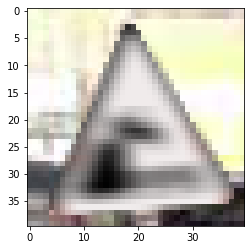

In [157]:
sg = SignGenerator('background_images')
img = Image.open('icons/1.10.png')
plt.imshow(sg.get_sample(img))

In [82]:
def generate_one_icon(args):
    """
    Функция, генерирующая синтетические данные для одного класса.
    :param args: Это список параметров: [путь до файла с иконкой, путь до выходной папки, путь до папки с фонами, число примеров каждого класса]
    """
    ### YOUR CODE HERE
    icon_path, output_folder, background_path, samples_per_class = args
    class_name = icon_path.split('/')[-1][:-4]
    sg = SignGenerator(background_path)
    for i in range(samples_per_class):
        image = Image.open(icon_path)
        sample = sg.get_sample(image)
        path = os.path.join(output_folder, class_name, f'{class_name}-{i}.png')
        cv2.imwrite(path, cv2.cvtColor(sample, cv2.COLOR_RGB2BGR))


def generate_all_data(output_folder, icons_path, background_path, samples_per_class=1000):
    """
    Функция, генерирующая синтетические данные.
    Эта функция запускает пул параллельно работающих процессов, каждый из которых будет генерировать иконку своего типа.
    Это необходимо, так как процесс генерации очень долгий.
    Каждый процесс работает в функции generate_one_icon.
    :param output_folder: Путь до выходной директории
    :param icons_path: Путь до директории с иконками
    :param background_path: Путь до директории с картинками фона
    :param samples_per_class: Количество примеров каждого класса, которые надо сгенерировать
    """
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)
    for icon in os.listdir(icons_path):
        icon_folder = os.path.join(output_folder, icon[:-4])
        if not os.path.isdir(icon_folder):
            os.mkdir(icon_folder)
    with ProcessPoolExecutor(8) as executor:
        params = [[os.path.join(icons_path, icon_file), output_folder, background_path, samples_per_class]
                  for icon_file in os.listdir(icons_path)]
        list(tqdm.tqdm(executor.map(generate_one_icon, params)))

In [159]:
generate_all_data('synthetic-train', 'icons', 'background_images')

205it [1:21:58, 23.99s/it]


In [161]:
!zip -r -q synthetic.zip synthetic-train

In [162]:
!cp synthetic.zip drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 3/CV/09_Traffic_signs/synthetic.zip

Get synthetic data, saved to Google drive

In [13]:
!cp drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 3/CV/09_Traffic_signs/synthetic.zip synthetic.zip

In [14]:
!unzip -q synthetic.zip -d ./

#### Train on original + synthetic data

In [83]:
def train_synt_classifier():
    """Функция для обучения простого классификатора на смеси исходных и синтетических данных."""
    ### YOUR CODE HERE
    # ds_train = DatasetRTSD(root_folders=['./cropped-train', './synthetic-train'], path_to_classes_json='./classes.json')
    ds_train = DatasetRTSD(root_folders=['./synthetic-train'], path_to_classes_json='./classes.json')
    dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=2)

    trainer = pl.Trainer(max_epochs=1,
                         precision=16,
                         accelerator='gpu', 
                         devices=1,
                         logger=False,
                         enable_checkpointing=False)
    
    model = CustomNetwork(pretrained=True)
    trainer.fit(model, dl_train)
    torch.save(model.to('cpu').state_dict(), "simple_model_with_synt.pth")
    return model

In [84]:
model = train_synt_classifier()

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit native Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 25.8 M
---------------------------------
24.4 M    Trainable params
1.4 M     Non-trainable params
25.8 M    Total params
51.633    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
# 4 layers, lr=5e-5, rare_recall = 0.39, freq_recall = 0.84
# 4 layers, lr=1e-5, rare_recall = 0.25, freq_recall = 0.79
# 5 layers, lr=1e-4, rare_recall = 0.37, freq_recall = 0.84
# 3 layers, lr=1e-4, rare_recall = 0.25, freq_recall = 0.74
# 4 layers, lr=5e-5, rare_recall = 0.38, freq_recall = 0.83


In [86]:
%%time
total_acc, rare_recall, freq_recall = test_classifier(model, 
                                                      'smalltest', 
                                                      'classes.json', 
                                                      'smalltest_annotations.csv')

print(f'total_acc = {total_acc:.2f}, rare_recall = {rare_recall:.2f}, freq_recall = {freq_recall:.2f}')

total_acc = 0.56, rare_recall = 0.41, freq_recall = 0.58
CPU times: user 53.5 s, sys: 1.13 s, total: 54.6 s
Wall time: 55.3 s


In [85]:
!cp simple_model_with_synt.pth drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 3/CV/09_Traffic_signs/simple_model_with_synt.pth